In [84]:
import os
import pandas as pd
import datetime
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import CuDNNLSTM
from keras.layers import TimeDistributed
from keras.utils import generic_utils
from keras.utils import Sequence
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
import numpy as np
import scipy 
import math
import h5py
import time
import copy
from sklearn.metrics import mean_absolute_error
from numpy.random import seed
seed(123)
from tensorflow import set_random_seed
set_random_seed(456)

In [4]:
import tensorflow as tf
import keras
print(os.getcwd())
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
tf.keras.backend.set_session(tf.Session(config=config))
#config = tf.ConfigProto( device_count = {'GPU': 1 , 'CPU': 56} ) 
#sess = tf.Session(config=config) 
#keras.backend.set_session(sess)
#sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

/home/whsu014/dev/mlrig/Experiments
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1011454928711085629
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 4523506320290111442
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7801326797
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2279616840177517810
physical_device_desc: "device: 0, name: GeForce RTX 2080, pci bus id: 0000:0a:00.0, compute capability: 7.5"
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 7782773556
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14146744377013638174
physical_device_desc: "device: 1, name: GeForce RTX 2080, pci bus id: 0000:42:00.0, compute capability: 7.5"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 8328103310966344648
physical_device_desc: "device: XLA_GPU device"
, name: "/dev

In [150]:
VIEW_df = pd.read_csv('/home/whsu014/data/Cholesterol_PHH_360dayspy_with_true_values_01day_ethn_coded_PREDICT_Variables_sbp2dbp2.csv')
print(VIEW_df.shape)
print(VIEW_df.columns)

(2099160, 51)
Index(['Unnamed: 0', 'STUDENT_INDEX_MASTER', 'DATE', 'QUARTERS', 'AGE',
       'ETHNICITY', 'SEX', 'NZDEP', 'TEST', 'HDL', 'LDL', 'TRI', 'TCL',
       'TCHDL', 'STATINS', 'ATORVASTATIN', 'SIMVASTATIN',
       'CHOLESTEROL_LOWERING', 'ARBs', 'ACE', 'ALPHA_BLOCKERS',
       'BETA_BLOCKERS', 'BLOOD_PRESSURE_LOWERING', 'LIPID_LOWERING',
       'DIURETICS', 'ANTIANGINAL_ANTIARRYTHMIC', 'CALCIUM_CHANNEL_BLOCKERS',
       'ANTIHYPERTENSIVES', 'CARDIAC_GLYCOSIDES', 'NITRATES',
       'SYMPATHOMIMETIC', 'OTHERS', 'ANTIPLATELETS', 'ANTICOAGULANTS',
       'TRUE_HDL', 'TRUE_LDL', 'TRUE_TRI', 'TRUE_TCL', 'TRUE_TCHDL', 'SBP',
       'SMOKING', 'EN_TCHDL', 'HX_DIABETES', 'FAMILY_HISTORY', 'DBP', 'HX_CVD',
       'GEN_LIPID', 'RENAL', 'HX_DIABETES_YR', 'SBP2', 'DBP2'],
      dtype='object')


In [151]:
VIEW_sub_df = VIEW_df[['STUDENT_INDEX_MASTER', 'DATE', 'QUARTERS', 
                       'AGE', 'ETHNICITY', 'SEX', 'NZDEP', 'TEST', 
                       'HDL', 'LDL', 'TRI', 'TCL', 'TCHDL', 'STATINS', 
                       'ATORVASTATIN', 'SIMVASTATIN', 'SBP', 'DBP',
                       'SBP2', 'DBP2', 'SMOKING', 'EN_TCHDL', 
                       'HX_DIABETES', 'FAMILY_HISTORY', 'HX_CVD', 
                       'GEN_LIPID', 'RENAL', 'HX_DIABETES_YR']]
print(VIEW_sub_df.shape)
print(VIEW_sub_df.isnull().sum())

(2099160, 28)
STUDENT_INDEX_MASTER          0
DATE                          0
QUARTERS                      0
AGE                           0
ETHNICITY                     0
SEX                           0
NZDEP                         0
TEST                          0
HDL                           0
LDL                           0
TRI                           0
TCL                           0
TCHDL                         0
STATINS                       0
ATORVASTATIN                  0
SIMVASTATIN                   0
SBP                           0
DBP                           0
SBP2                          0
DBP2                        112
SMOKING                      28
EN_TCHDL                  23884
HX_DIABETES                   0
FAMILY_HISTORY                0
HX_CVD                        0
GEN_LIPID                     0
RENAL                   1440208
HX_DIABETES_YR          1417864
dtype: int64


In [152]:
print("ETHNICITY", VIEW_sub_df.ETHNICITY.unique())
print("SEX", VIEW_sub_df.SEX.unique())
print("NZDEP", VIEW_sub_df.NZDEP.unique())
print("SMOKING", VIEW_sub_df.SMOKING.unique())
print("HX_DIABETES", VIEW_sub_df.HX_DIABETES.unique())
print("FAMILY_HISTORY", VIEW_sub_df.FAMILY_HISTORY.unique())
print("HX_CVD", VIEW_sub_df.HX_CVD.unique())
print("GEN_LIPID", VIEW_sub_df.GEN_LIPID.unique())
print("RENAL", VIEW_sub_df.RENAL.unique())

ETHNICITY ['E' 'A' 'B' 'H' 'C' 'G' 'D' 'F']
SEX ['F' 'M']
NZDEP [4 1 3 5 2]
SMOKING [ 0.  3.  1.  4.  5.  2. nan]
HX_DIABETES [0. 1.]
FAMILY_HISTORY [1. 0.]
HX_CVD [0. 1.]
GEN_LIPID [0. 1. 4. 2. 3.]
RENAL [nan  0.  1.  2.  3.]


In [153]:
# find number of nan in SMOKING and RENAL
print(VIEW_sub_df.SMOKING.isnull().sum())
print(VIEW_sub_df.RENAL.isnull().sum())
print(VIEW_sub_df.HX_DIABETES_YR.isnull().sum())

28
1440208
1417864


In [154]:
##  drop DATE, RENAL and HX_DIABETES_YR for now 
VIEW_sub_df = VIEW_df[['STUDENT_INDEX_MASTER', 'DATE','QUARTERS', 
                       'AGE', 'ETHNICITY', 'SEX', 'NZDEP', 'TEST', 
                       'HDL', 'LDL', 'TRI', 'TCL', 'TCHDL', 'STATINS', 
                       'ATORVASTATIN', 'SIMVASTATIN', 'SBP', 'DBP',
                       'SBP2', 'DBP2', 'SMOKING', 'EN_TCHDL', 
                       'HX_DIABETES', 'FAMILY_HISTORY', 'HX_CVD', 
                       'GEN_LIPID', 'RENAL', 'HX_DIABETES_YR']]
# remove individuals that 
# contains nans
print(VIEW_sub_df.shape)
VIEW_sub_df = VIEW_sub_df[np.isfinite(VIEW_sub_df['DBP2'])]
VIEW_sub_df = VIEW_sub_df[np.isfinite(VIEW_sub_df['SMOKING'])]
VIEW_sub_df = VIEW_sub_df[np.isfinite(VIEW_sub_df['EN_TCHDL'])]
print(VIEW_sub_df.shape)

(2099160, 28)
(2075136, 28)


In [155]:
print(VIEW_sub_df[VIEW_sub_df.ETHNICITY == 'A'].shape[0]//28)
print(VIEW_sub_df[VIEW_sub_df.ETHNICITY == 'B'].shape[0]//28)
print(VIEW_sub_df[VIEW_sub_df.ETHNICITY == 'C'].shape[0]//28)
print(VIEW_sub_df[VIEW_sub_df.ETHNICITY == 'D'].shape[0]//28)
print(VIEW_sub_df[VIEW_sub_df.ETHNICITY == 'E'].shape[0]//28)
print(VIEW_sub_df[VIEW_sub_df.ETHNICITY == 'F'].shape[0]//28)
print(VIEW_sub_df[VIEW_sub_df.ETHNICITY == 'G'].shape[0]//28)
print(VIEW_sub_df[VIEW_sub_df.ETHNICITY == 'H'].shape[0]//28)

3597
44184
6486
1234
7236
50
2333
8992


In [156]:
# Combine D, F and G
VIEW_sub_A_df = VIEW_sub_df[VIEW_sub_df.ETHNICITY == 'A']
VIEW_sub_B_df = VIEW_sub_df[VIEW_sub_df.ETHNICITY == 'B']
VIEW_sub_C_df = VIEW_sub_df[VIEW_sub_df.ETHNICITY == 'C']
VIEW_sub_D_df = VIEW_sub_df[VIEW_sub_df.ETHNICITY.isin(['D', 'F', 'G'])] # MELAA, Other and Other_Asian
VIEW_sub_E_df = VIEW_sub_df[VIEW_sub_df.ETHNICITY == 'E']
VIEW_sub_H_df = VIEW_sub_df[VIEW_sub_df.ETHNICITY == 'H']
print(VIEW_sub_A_df.shape[0]//28)
print(VIEW_sub_B_df.shape[0]//28)
print(VIEW_sub_C_df.shape[0]//28)
print(VIEW_sub_D_df.shape[0]//28)
print(VIEW_sub_E_df.shape[0]//28)
print(VIEW_sub_H_df.shape[0]//28)

3597
44184
6486
3617
7236
8992


In [157]:
# random sampling unique ID 
# to control ethn imbalance
ethn_A_list = VIEW_sub_A_df.STUDENT_INDEX_MASTER.unique()
ethn_B_list = VIEW_sub_B_df.STUDENT_INDEX_MASTER.unique()
ethn_C_list = VIEW_sub_C_df.STUDENT_INDEX_MASTER.unique()
ethn_D_list = VIEW_sub_D_df.STUDENT_INDEX_MASTER.unique()
ethn_E_list = VIEW_sub_E_df.STUDENT_INDEX_MASTER.unique()
ethn_H_list = VIEW_sub_H_df.STUDENT_INDEX_MASTER.unique()
ethn_A_sample = list(np.random.choice(ethn_A_list, 3333, replace=False))
ethn_B_sample = list(np.random.choice(ethn_B_list, 3335, replace=False)) # over sample Europeans
ethn_C_sample = list(np.random.choice(ethn_C_list, 3333, replace=False)) # to make a data of 
ethn_D_sample = list(np.random.choice(ethn_D_list, 3333, replace=False)) # 20,000 individuals
ethn_E_sample = list(np.random.choice(ethn_E_list, 3333, replace=False))
ethn_H_sample = list(np.random.choice(ethn_H_list, 3333, replace=False))
print(VIEW_sub_df.shape)
ethn_sample = ethn_A_sample + ethn_B_sample + ethn_C_sample + \
              ethn_D_sample + ethn_E_sample + ethn_H_sample
VIEW_sub_df = VIEW_sub_df[VIEW_sub_df.STUDENT_INDEX_MASTER.isin(ethn_sample)]
print(VIEW_sub_df.shape)


(2075136, 28)
(560000, 28)


In [158]:
print(VIEW_sub_df.columns) 
#check ETHN distribution
print(VIEW_sub_df[VIEW_sub_df.ETHNICITY == "A"].shape[0])
print(VIEW_sub_df[VIEW_sub_df.ETHNICITY == "B"].shape[0])
print(VIEW_sub_df[VIEW_sub_df.ETHNICITY == "C"].shape[0])
print(VIEW_sub_df[VIEW_sub_df.ETHNICITY == "D"].shape[0])
print(VIEW_sub_df[VIEW_sub_df.ETHNICITY == "F"].shape[0])
print(VIEW_sub_df[VIEW_sub_df.ETHNICITY == "G"].shape[0])
print(VIEW_sub_df[VIEW_sub_df.ETHNICITY == "E"].shape[0])
print(VIEW_sub_df[VIEW_sub_df.ETHNICITY == "H"].shape[0])

Index(['STUDENT_INDEX_MASTER', 'DATE', 'QUARTERS', 'AGE', 'ETHNICITY', 'SEX',
       'NZDEP', 'TEST', 'HDL', 'LDL', 'TRI', 'TCL', 'TCHDL', 'STATINS',
       'ATORVASTATIN', 'SIMVASTATIN', 'SBP', 'DBP', 'SBP2', 'DBP2', 'SMOKING',
       'EN_TCHDL', 'HX_DIABETES', 'FAMILY_HISTORY', 'HX_CVD', 'GEN_LIPID',
       'RENAL', 'HX_DIABETES_YR'],
      dtype='object')
93324
93380
93324
32116
1260
59948
93324
93324


In [159]:
print(VIEW_sub_df.columns)
print(VIEW_sub_df.DATE.iloc[0])
print(VIEW_sub_df.HX_DIABETES_YR.iloc[170])
print(VIEW_sub_df.isnull().sum())

Index(['STUDENT_INDEX_MASTER', 'DATE', 'QUARTERS', 'AGE', 'ETHNICITY', 'SEX',
       'NZDEP', 'TEST', 'HDL', 'LDL', 'TRI', 'TCL', 'TCHDL', 'STATINS',
       'ATORVASTATIN', 'SIMVASTATIN', 'SBP', 'DBP', 'SBP2', 'DBP2', 'SMOKING',
       'EN_TCHDL', 'HX_DIABETES', 'FAMILY_HISTORY', 'HX_CVD', 'GEN_LIPID',
       'RENAL', 'HX_DIABETES_YR'],
      dtype='object')
2009-07-01 00:00:00
2007.0
STUDENT_INDEX_MASTER         0
DATE                         0
QUARTERS                     0
AGE                          0
ETHNICITY                    0
SEX                          0
NZDEP                        0
TEST                         0
HDL                          0
LDL                          0
TRI                          0
TCL                          0
TCHDL                        0
STATINS                      0
ATORVASTATIN                 0
SIMVASTATIN                  0
SBP                          0
DBP                          0
SBP2                         0
DBP2                   

In [160]:
# encode ID strings to numbers
# create a dictionary to store 
# its mapping 
VIEW_sub_v = VIEW_sub_df.values
ID_to_num = {}
num = 0
for i in range(len(VIEW_sub_v)):
    if VIEW_sub_v[i, 0] not in ID_to_num:
        ID_to_num[VIEW_sub_v[i, 0]] = num
        num += 1
    VIEW_sub_v[i, 0] = ID_to_num[VIEW_sub_v[i, 0]]
# if ethn is , F or G change to D
for i in range(len(VIEW_sub_v)):
    if VIEW_sub_v[i, 4] in ['F', 'G']:
        VIEW_sub_v[i, 4] = 'D'
# change date into datetime object 26, 27
for i in range(len(VIEW_sub_v)):
    VIEW_sub_v[i, 1] = datetime.datetime.strptime(VIEW_sub_v[i, 1], '%Y-%m-%d %H:%M:%S')
    # process RENAL values
    # change RENAL [nan  0.  1.  2.  3.]
    # to RENAL [0, 1, 2, 3, 4]
    if np.isnan(VIEW_sub_v[i, 26]):
        VIEW_sub_v[i, 26] = 0
    else:
        VIEW_sub_v[i, 26] = VIEW_sub_v[i, 26] + 1
    # process HX_DIABETES_YR values
    if np.isnan(VIEW_sub_v[i, 27]):
        VIEW_sub_v[i, 27] = 0
    else:
        VIEW_sub_v[i, 27] = VIEW_sub_v[i, 1].year - VIEW_sub_v[i, 27]

In [161]:
print(pd.isnull(VIEW_sub_v).sum())
print(VIEW_sub_v[0:100, 0])
print(VIEW_sub_v[0:100, 3])
print("ETHNICITY VALUES", np.unique(VIEW_sub_v[:, 4]))
print("RENAL VALUES", np.unique(VIEW_sub_v[:, 26]))
print("HX_DIABETES_YR VALUES", np.unique(VIEW_sub_v[:, 27]))
#check distribution of ETHNICITY in the first 5000 individuals
VIEW_sub_sub = VIEW_sub_v[0:(5000*28), :]
print(VIEW_sub_sub[VIEW_sub_sub[:, 4]== "A"].shape[0]//28)
print(VIEW_sub_sub[VIEW_sub_sub[:, 4]== "B"].shape[0]//28)
print(VIEW_sub_sub[VIEW_sub_sub[:, 4]== "C"].shape[0]//28)
print(VIEW_sub_sub[VIEW_sub_sub[:, 4]== "D"].shape[0]//28)
print(VIEW_sub_sub[VIEW_sub_sub[:, 4]== "E"].shape[0]//28)
print(VIEW_sub_sub[VIEW_sub_sub[:, 4]== "H"].shape[0]//28)

0
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
[59.0 60.0 60.0 60.0 60.0 61.0 61.0 61.0 61.0 62.0 62.0 62.0 62.0 63.0
 63.0 63.0 63.0 64.0 64.0 64.0 64.0 64.0 65.0 65.0 65.0 65.0 66.0 66.0
 54.0 55.0 55.0 55.0 55.0 56.0 56.0 56.0 56.0 57.0 57.0 57.0 57.0 58.0
 58.0 58.0 58.0 59.0 59.0 59.0 59.0 60.0 60.0 60.0 60.0 61.0 61.0 61.0
 63.0 63.0 64.0 64.0 64.0 64.0 65.0 65.0 65.0 65.0 66.0 66.0 66.0 66.0
 67.0 67.0 67.0 67.0 68.0 68.0 68.0 68.0 69.0 69.0 69.0 69.0 70.0 70.0
 49.0 49.0 49.0 49.0 50.0 50.0 50.0 50.0 51.0 51.0 51.0 51.0 52.0 52.0
 52.0 52.0]
ETHNICITY VALUES ['A' 'B' 'C' 'D' 'E' 'H']
RENAL VALUES [0 1.0 2.0 3.0 4.0]
HX_DIABETES_YR VALUES [0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 12.0 13.0 14.0 15.0 16.0
 17.0 18.0 19.0 20.0 21.0 22.0 23.0 24.0 25.0 26.0 27.0 28.0 29.0 30.0
 31.0 32.0 33.0 34.0 35.0 36.0 37.0 38.0 3

'STUDENT_INDEX_MASTER', 'DATE', 'QUARTERS', 'AGE', 'ETHNICITY', 'SEX',
       'NZDEP', 'TEST', 'HDL', 'LDL', 'TRI', 'TCL', 'TCHDL', 'STATINS',
       'ATORVASTATIN', 'SIMVASTATIN', 'SBP', 'DBP', 'SBP2', 'DBP2', 'SMOKING',
       'EN_TCHDL', 'HX_DIABETES', 'FAMILY_HISTORY', 'HX_CVD', 'GEN_LIPID',
       'RENAL', 'HX_DIABETES_YR'

In [162]:
# one hot encode categorical variables
for i in range(len(VIEW_sub_v)):
    if VIEW_sub_v[i, 5] == 'M':
        VIEW_sub_v[i, 5] = 0
    else:
        VIEW_sub_v[i, 5] = 1
        
ethn_v = np.zeros((len(VIEW_sub_v), 6))
ethn_idx = {'A': 0,
            'B': 1,
            'C': 2,
            'D': 3,
            'E': 4,
            'H': 5}

for i in range(len(VIEW_sub_v)):
    ethn_v[i, ethn_idx[VIEW_sub_v[i, 4]]] = 1

# reorganise columns  
# STUDENT_INDEX_MASTER, QUARTERS, AGE, SEX, NZDEP, 
# A, B, C, D, E, H
# SBP, DBP, SBP2, DBP2,
# SMOKING, EN_TCHDL, HX_DIABETES, FAMILY_HISTORY, HX_CVD, 
# GEN_LIPID, RENAL, HX_DIABETES_YR
# STATINS, ATORVASTATIN, SIMVASTATIN, 
# TEST, HDL, LDL, TRI, TCL, TCHDL
VIEW_sub_v1 = VIEW_sub_v[:, [0,2,3,5,6]] # Demographic variables + QUARTERS
VIEW_sub_v2 = VIEW_sub_v[:, [13,14,15]] # STATINS  PHH
VIEW_sub_v3 = VIEW_sub_v[:, [16,17,18,19,20,21,22,23,24,25,26,27]] # PREDICT variables
VIEW_sub_v4 = VIEW_sub_v[:, [7,8,9,10,11,12]] # CHOLESTEROLS TESTSAFE
VIEW_1hot_encoded_v = np.append(VIEW_sub_v1, ethn_v, axis= 1)
VIEW_1hot_encoded_v = np.append(VIEW_1hot_encoded_v, VIEW_sub_v3, \
                                axis=1)
VIEW_1hot_encoded_v = np.append(VIEW_1hot_encoded_v, VIEW_sub_v2, \
                                axis=1)
VIEW_1hot_encoded_v = np.append(VIEW_1hot_encoded_v, VIEW_sub_v4, \
                                axis=1)
print(VIEW_1hot_encoded_v.shape)

(560000, 32)


In [163]:
# normalise vectors to values between 0 and 1
#scaler = MinMaxScaler(feature_range=(0, 1))
#scaled_train = scaler.fit_transform(VIEW_1hot_encoded_v)
#decided to use standardise instead of normalise
print(np.unique(VIEW_1hot_encoded_v[:, -6]))
scaler = StandardScaler()
scaled_train = scaler.fit_transform(VIEW_1hot_encoded_v)
print("TEST VALUES", np.unique(scaled_train[:, -6]))
print("Value indicating test", max(np.unique(scaled_train[:, -6])))

[0 1]
TEST VALUES [-0.71651295  1.39564819]
Value indicating test 1.3956481893756667


(array([3.0000e+00, 1.5200e+02, 2.3300e+03, 1.1758e+04, 2.7160e+04,
        4.5367e+04, 5.9666e+04, 6.7795e+04, 7.1247e+04, 6.2932e+04,
        5.5210e+04, 4.4681e+04, 3.5214e+04, 2.6462e+04, 1.7798e+04,
        1.1776e+04, 7.7190e+03, 5.0030e+03, 2.9330e+03, 1.6420e+03,
        1.0420e+03, 7.4100e+02, 4.5100e+02, 2.5000e+02, 1.7200e+02,
        1.1800e+02, 1.0000e+02, 6.7000e+01, 3.2000e+01, 2.8000e+01,
        2.4000e+01, 1.9000e+01, 8.0000e+00, 1.1000e+01, 5.0000e+00,
        3.0000e+00, 6.0000e+00, 3.0000e+00, 1.0000e+00, 4.0000e+00,
        5.0000e+00, 6.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
        2.0000e+00, 3.0000e+00, 7.0000e+00, 4.0000e+00, 4.0000e+00,
        1.0000e+00, 0.0000e+00, 1.0000e+00, 2.0000e+00, 2.0000e+00,
        0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00,
        3.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 2.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 2.00

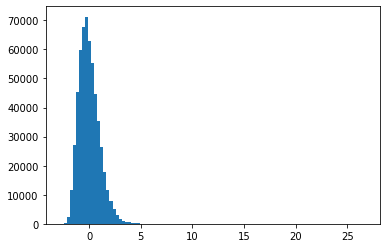

In [164]:
#pyplot.hist(VIEW_1hot_encoded_v[:, -1], bins= 100)
pyplot.hist(scaled_train[:, -1], bins= 100)

In [165]:
# Create test data array
# ensuring test does not 
# look foreward beyond 
# last test in the initial
# 8 quarters
number_of_inds = 5000#VIEW_1hot_encoded_v.shape[0]//28
start = 0
end = 28
value_indicating_test = max(np.unique(scaled_train[:, -6]))
value_indicating_no_test = min(np.unique(scaled_train[:, -6]))
scaled_test = np.empty([0, 32])
for i in range(number_of_inds):
    ind_v = copy.deepcopy(scaled_train[start:end, :])
    test_list = list(ind_v[0:8, -6])
    quarters_v = copy.deepcopy(ind_v[:, 1])
    age_v = copy.deepcopy(ind_v[:, 2])
    idx = len(test_list) - 1 - \
          test_list[::-1].index(value_indicating_test)
    last_v = copy.deepcopy(ind_v[idx, -6:])
    last_v[0] = value_indicating_no_test #this might be the wrong assumption
    for j in range((idx+1),28):
        ind_v[j, -6:] = last_v
        #ind_v[j, -6] = 0  # set TEST to 0
    ind_v[:, 1] = quarters_v
    ind_v[:, 2] = age_v
    scaled_test = np.append(scaled_test, \
                            ind_v, axis = 0)
    start = end
    end += 28
print(scaled_train.shape)
print(scaled_test.shape)
#VIEW_1hot_encoded_v = VIEW_1hot_encoded_v[0:(number_of_inds*28), :]
#print(VIEW_1hot_encoded_v.shape)
#print(VIEW_1hot_encoded_test_v.shape)

(560000, 32)
(140000, 32)


In [136]:
#inspect inds
ind = 1
print(np.around(scaled_test[(ind*28):((ind+1)*28)+1, -9:], 2))

[[-0.84 -0.38 -0.64 -0.72 -0.47  0.48  0.3   0.43  0.71]
 [-0.84 -0.38 -0.64 -0.72 -0.33  0.62  0.07  0.46  0.54]
 [-0.84 -0.38 -0.64  1.39 -0.3   0.7   0.06  0.52  0.56]
 [-0.84 -0.38 -0.64 -0.72 -0.3   0.7   0.06  0.52  0.56]
 [-0.84 -0.38 -0.64 -0.72 -0.3   0.7   0.06  0.52  0.56]
 [-0.84 -0.38 -0.64 -0.72 -0.3   0.7   0.06  0.52  0.56]
 [-0.84 -0.38 -0.64 -0.72 -0.3   0.7   0.06  0.52  0.56]
 [-0.84 -0.38 -0.64 -0.72 -0.3   0.7   0.06  0.52  0.56]
 [-0.84 -0.38 -0.64 -0.72 -0.3   0.7   0.06  0.52  0.56]
 [-0.84 -0.38 -0.64 -0.72 -0.3   0.7   0.06  0.52  0.56]
 [-0.84 -0.38 -0.64 -0.72 -0.3   0.7   0.06  0.52  0.56]
 [-0.84 -0.38 -0.64 -0.72 -0.3   0.7   0.06  0.52  0.56]
 [-0.84 -0.38 -0.64 -0.72 -0.3   0.7   0.06  0.52  0.56]
 [-0.84 -0.38 -0.64 -0.72 -0.3   0.7   0.06  0.52  0.56]
 [-0.84 -0.38 -0.64 -0.72 -0.3   0.7   0.06  0.52  0.56]
 [-0.84 -0.38 -0.64 -0.72 -0.3   0.7   0.06  0.52  0.56]
 [-0.84 -0.38 -0.64 -0.72 -0.3   0.7   0.06  0.52  0.56]
 [-0.84 -0.38 -0.64 -0.72 -0.3 

In [145]:
#STUDENT_INDEX_MASTER, QUARTERS, AGE, SEX, NZDEP, 
# A, B, C, D, E, H (10)
# SBP, DBP, SBP2, DBP2,
# SMOKING, EN_TCHDL, HX_DIABETES, FAMILY_HISTORY, HX_CVD, 
# GEN_LIPID, RENAL, HX_DIABETES_YR
# STATINS, ATORVASTATIN, SIMVASTATIN, 
# TEST, HDL, LDL, TRI, TCL, TCHDL
#VIEW_1hot_encoded_non_sparse_v = VIEW_1hot_encoded_v[:, [0,1,2,3,4,5,6,\
#                                                         7,8,9,10,11,12,\
#                                                         13,14,15,16,23,\
#                                                         24,25,26,27,28,\
#                                                         29,30,31]]
#VIEW_1hot_encoded_test_non_sparse_v = VIEW_1hot_encoded_test_v[:, [0,1,2,3,4,5,6,\
#                                                         7,8,9,10,11,12,\
#                                                         13,14,15,16,23,\
#                                                         24,25,26,27,28,\
#                                                         29,30,31]]
#print(VIEW_1hot_encoded_v.shape)
#print(VIEW_1hot_encoded_non_sparse_v.shape)
#print(VIEW_1hot_encoded_test_v.shape)
#print(VIEW_1hot_encoded_test_non_sparse_v.shape)

(560000, 32)
(560000, 26)
(560000, 32)
(560000, 26)


In [166]:
###############################################
# set up data for training with generator
# build x and y list
###############################################

def generate_x_y(scaled, number_of_inds, folds):
    x_list = []
    y_list = []
    x = np.empty([0, 32])
    ground_truth = np.empty([0, 32])
    ##################
    entry_start = 0
    len_list = [0]
    len_list_x = [0]
    len_list_y = [0]
    id_count = 0
    ##################
    #number_of_inds = len(scaled)//28
    for i in range(number_of_inds):
        start = i*28
        end = (i+1)*28
        ind_data = scaled[start:end, :]
        ##################################
        # create ground truth for forecast
        ##################################
        id_count += 1
        ind_x = ind_data[:-1, :-9]
        ind_y = ind_data[1:, -9:]
        ind_xy = np.append(ind_x, ind_y, axis=1)
        ground_truth = np.append(ground_truth, ind_xy, axis=0)
        ##################################
        # create data for 1 step forecast
        ##################################
        for i in range(len(ind_data)-1):
            x_list.append(ind_data[:(i+1), :])
            y_list.append(ind_data[(i+1), -9:])
            if i == len(ind_data)-2:
                x = np.append(x, x_list[-1], axis=0)
                n_rows = x_list[-1].shape[0]
                entry_start += n_rows
                len_list.append(entry_start)
        # store the indices to fold
        # changed from 10 fold to 2 fold 
        # due to amount of data and fair 
        # comparison with depmix
        if id_count % (number_of_inds//folds) == 0 and \
            id_count != 0:
                len_list_x.append(len(x_list))
                len_list_y.append(len(y_list))
    return x_list, y_list, len_list_x, len_list_y, len_list, x, ground_truth
x_train_list, y_train_list, \
len_list_x_train, len_list_y_train, \
len_list_train, x_train, ground_truth_train = generate_x_y(scaled_train, number_of_inds, 2)

x_test_list, y_test_list, \
len_list_x_test, len_list_y_test, \
len_list_test, x_test, ground_truth_test = generate_x_y(scaled_test, number_of_inds, 2)

In [25]:
start_idx = 0
size = len(len_list_train)//2
print(len(len_list_train))
print(size)
start = len_list_train[start_idx]
end = len_list_train[start_idx+size]
print(start)
print(end)
print("x_train[start:end, :-9] shape", x_train[start:end, :-9].shape)
print("yhat shape", yhat.shape)

5001
2500
0
67500
x_train[start:end, :-9] shape (67500, 23)
yhat shape (54000, 9)


In [ ]:
import tensorflow as tf
###########################################
# two fold cross validatioin
###########################################

# keras generators need to be 
# infinitely iterable
def train_generator(x_list, y_list):
    # 0.1 validatioin split
    train_length = (len(x_list)//10)*9
    while True:
        for i in range(train_length):
            train_x = np.array([x_list[i]])
            train_y = np.array([y_list[i]])
            yield train_x, train_y
            
def val_generator(x_list, y_list):
#    # 0.1 validation split
    val_length = len(x_list)//10
    while True:
        for i in range(-val_length, 0, 1):
            val_x = np.array([x_list[i]])
            val_y = np.array([y_list[i]])
            yield val_x, val_y
            
###########################################
# use keras.utils.Sequence for 
# thread-safe multiprocess
###########################################
start_idx = 0
size = len(len_list_train)//2 #changed from 10

rmse_lstm_list = []
rmse_naive_list = []

complete_inv_y = np.empty([0, 32])
complete_inv_yhat = np.empty([0, 32])
complete_inv_naive = np.empty([0, 32])

start_outside = time.time()

for f in range(2):  #2
    print("Fold: ", f+1)
    ##################################
    # forecast using LSTM
    ##################################
    lstm_start = len_list_x_train[f]
    lstm_end = len_list_x_train[f+1]
    

    train1_x = x_train_list[:lstm_start]
    train2_x = x_train_list[lstm_end:]
    train_x = train1_x + train2_x
    
    test_x = x_test_list[lstm_start:lstm_end]
    
    train1_y = y_train_list[:lstm_start]
    train2_y = y_train_list[lstm_end:]
    train_y = train1_y + train2_y
    
    test_y = y_test_list[lstm_start:lstm_end]
    
    # time training
    start_time = time.time()
    # design network
    #with tf.device('/device:GPU:0'):
    with tf.Session(config = tf.ConfigProto(log_device_placement = True)):        
        model = Sequential()
        model.add(CuDNNLSTM(256, return_sequences=True,
                        input_shape=(None, 32)))
        model.add(CuDNNLSTM(256, return_sequences=True))
        model.add(CuDNNLSTM(256))
        model.add(Dense(9))
        model.compile(loss='mae', optimizer='adam')
        weight = "weights" + str(f) + ".hdf5"
        checkpointer = ModelCheckpoint(filepath=weight,
                                    monitor='val_loss', verbose=1,
                                    save_best_only=True)
        history = model.fit_generator(generator=train_generator(train_x, 
                                                                train_y), 
                                        steps_per_epoch=(len(train_x)//10)*9, 
                                        epochs=50, 
                                        validation_data=val_generator(train_x, 
                                                                    train_y), 
                                        validation_steps=len(train_x)//10, 
                                        callbacks=[checkpointer], 
                                        verbose=2, shuffle=False)

    # plot history
    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='validation')
    pyplot.legend()
    pyplot.show()
    
    end_time = time.time()
    print("Training LSTM: ", end_time - start_time)
    #########################################
    # LSTM prediction
    #########################################
    model.load_weights(weight)
    yhat = np.empty((0, 9))
    forecast = np.empty((0, 9))
    for i in range(len(test_x)):
        #yhat_pred = model.predict(np.array([test_x[i]]))
        #print("yhat_pred.shape: ", yhat_pred.shape)
        #yhat = np.append(yhat, yhat_pred, axis=0)
        if len(test_x[i]) < 8:
            yhat_pred = model.predict(np.array([test_x[i]]))
        elif len(test_x[i]) == 8:
            yhat_pred = model.predict(np.array([test_x[i]]))
            #print("forecast shape", forecast.shape)
            #print("yhat_pred shape", yhat_pred.shape)
            forecast = np.append(forecast, yhat_pred, axis=0)
        elif len(test_x[i]) > 8:
            adjusted_y = np.append(test_x[i][:-len(forecast), -9:], forecast, axis=0)
            test_x[i] = np.append(test_x[i][:, :-9], adjusted_y, axis=1)
            yhat_pred = model.predict(np.array([test_x[i]]))
            #print("forecast shape", forecast.shape)
            #print("yhat_pred shape", yhat_pred.shape)
            forecast = np.append(forecast, yhat_pred, axis=0)    
            if len(test_x[i]) == 27:
                forecast = np.empty((0, 9))
        #print("yhat shape", yhat.shape)
        #print("yhat_pred shape", yhat_pred.shape)
        yhat = np.append(yhat, yhat_pred, axis=0)
    start = len_list_train[start_idx]
    end = len_list_train[start_idx+size]
    #print("x_train[start:end, :-9] shape", x_train[start:end, :-9].shape)
    #print("yhat shape", yhat.shape)
    xyhat = np.append(x_train[start:end, :-9], yhat, axis=1)
    inv_yhat = scaler.inverse_transform(xyhat)
    inv_y = scaler.inverse_transform(ground_truth_train[start:end, :])
    if np.array_equal(inv_y[:, :-9], inv_yhat[:, :-9]):
        print("inv_y x and inv_yhat x are the same")
    else:
        print("inv_y x and inv_yhat x are not the same")
    end_time = time.time()
    print("Training and Testing LSTM: ", end_time - start_time)
    #########################################################
    # forecasting using Vector Autoregression (VAR) and Naive
    #########################################################
    rmse_lstm = math.sqrt(mean_squared_error(inv_y[:, -9:], inv_yhat[:, -9:]))
    rmse_lstm_list.append(rmse_lstm)
    
    complete_inv_y = np.append(complete_inv_y, inv_y, axis=0)
    complete_inv_yhat = np.append(complete_inv_yhat, inv_yhat, axis=0)

    end_time = time.time()
    print("End of fold "+str(f)+":", end_time - start_time)
    start_idx += size
print("rmse_lstm_list")
print(rmse_lstm_list)
end_outside = time.time()
print("Entire process took:", end_outside - start_outside)

Fold:  1
Epoch 1/50
 - 323s - loss: 0.3542 - val_loss: 0.2926

Epoch 00001: val_loss improved from inf to 0.29261, saving model to weights0.hdf5
Epoch 2/50


In [25]:
complete_inv_y_df = pd.DataFrame(complete_inv_y)
complete_inv_y_df.columns = ['STUDENT_INDEX_MASTER', 'QUARTERS',
                             'AGE', 'SEX', 'NZDEP', 'ETHN_A', 
                             'ETHN_B', 'ETHN_C', 'ETHN_D', 
                             'ETHN_E', 'ETHN_H',# (10)
                             'SBP', 'DBP', 'SBP2', 'DBP2',
                             'SMOKING', 'EN_TCHDL', 'HX_DIABETES',
                             'FAMILY_HISTORY', 'HX_CVD', 'GEN_LIPID',
                             'RENAL', 'HX_DIABETES_YR', 'STATINS',
                             'ATORVASTATIN', 'SIMVASTATIN', 
                             'TEST', 'HDL', 'LDL', 'TRI', 'TCL', 
                             'TCHDL']
complete_inv_y_df.to_csv('/home/whsu014/data/LSTM_experiment_train2500inds_ID_y.csv', sep=",")
complete_inv_yhat_df = pd.DataFrame(complete_inv_yhat)
complete_inv_yhat_df.columns = ['STUDENT_INDEX_MASTER', 'QUARTERS',
                             'AGE', 'SEX', 'NZDEP', 'ETHN_A', 
                             'ETHN_B', 'ETHN_C', 'ETHN_D', 
                             'ETHN_E', 'ETHN_H',# (10)
                             'SBP', 'DBP', 'SBP2', 'DBP2',
                             'SMOKING', 'EN_TCHDL', 'HX_DIABETES',
                             'FAMILY_HISTORY', 'HX_CVD', 'GEN_LIPID',
                             'RENAL', 'HX_DIABETES_YR', 'STATINS',
                             'ATORVASTATIN', 'SIMVASTATIN', 
                             'TEST', 'HDL', 'LDL', 'TRI', 'TCL', 
                             'TCHDL']
complete_inv_yhat_df.to_csv('/home/whsu014/data/LSTM_experiment_train2500inds_ID_yhat.csv', sep=",")


In [66]:
complete_inv_y1_df = pd.read_csv('/home/whsu014/data/LSTM_experiment_train2500inds_y.csv')
complete_inv_yhat1_df = pd.read_csv('/home/whsu014/data/LSTM_experiment_train2500inds_yhat.csv')
print(complete_inv_y1_df.columns)
print(complete_inv_y1_df.shape)
complete_inv_y = complete_inv_y1_df.values[:, 1:]
complete_inv_yhat = complete_inv_yhat1_df.values[:, 1:]
print(complete_inv_y.shape)
print(complete_inv_yhat.shape)

Index(['Unnamed: 0', 'STUDENT_INDEX_MASTER', 'QUARTERS', 'AGE', 'SEX', 'NZDEP',
       'ETHN_A', 'ETHN_B', 'ETHN_C', 'ETHN_D', 'ETHN_E', 'ETHN_H', 'SBP',
       'DBP', 'SBP2', 'DBP2', 'SMOKING', 'EN_TCHDL', 'HX_DIABETES',
       'FAMILY_HISTORY', 'HX_CVD', 'GEN_LIPID', 'RENAL', 'HX_DIABETES_YR',
       'STATINS', 'ATORVASTATIN', 'SIMVASTATIN', 'TEST', 'HDL', 'LDL', 'TRI',
       'TCL', 'TCHDL'],
      dtype='object')
(135000, 33)
(135000, 32)
(135000, 32)


In [116]:
print(complete_inv_y.shape)
print(complete_inv_yhat.shape)
print(complete_inv_y[0:20, 0])
num_to_ID = {v: k for k, v in ID_to_num.items()}
complete_inv_y = np.array(complete_inv_y, dtype= np.object)
complete_inv_yhat = np.array(complete_inv_yhat, dtype= np.object)
for i in range(len(complete_inv_y)):
    complete_inv_y[i, 0] = num_to_ID[round(complete_inv_y[i, 0])]
    complete_inv_yhat[i, 0] = num_to_ID[round(complete_inv_yhat[i, 0])]
print(complete_inv_y[0:20, 0])
print(complete_inv_yhat[0:20, 0]) 

(135000, 32)
(135000, 32)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
['STGeicKXNtxz' 'STGeicKXNtxz' 'STGeicKXNtxz' 'STGeicKXNtxz'
 'STGeicKXNtxz' 'STGeicKXNtxz' 'STGeicKXNtxz' 'STGeicKXNtxz'
 'STGeicKXNtxz' 'STGeicKXNtxz' 'STGeicKXNtxz' 'STGeicKXNtxz'
 'STGeicKXNtxz' 'STGeicKXNtxz' 'STGeicKXNtxz' 'STGeicKXNtxz'
 'STGeicKXNtxz' 'STGeicKXNtxz' 'STGeicKXNtxz' 'STGeicKXNtxz']
['STGeicKXNtxz' 'STGeicKXNtxz' 'STGeicKXNtxz' 'STGeicKXNtxz'
 'STGeicKXNtxz' 'STGeicKXNtxz' 'STGeicKXNtxz' 'STGeicKXNtxz'
 'STGeicKXNtxz' 'STGeicKXNtxz' 'STGeicKXNtxz' 'STGeicKXNtxz'
 'STGeicKXNtxz' 'STGeicKXNtxz' 'STGeicKXNtxz' 'STGeicKXNtxz'
 'STGeicKXNtxz' 'STGeicKXNtxz' 'STGeicKXNtxz' 'STGeicKXNtxz']


In [69]:
print(VIEW_df.columns)
VIEW_v = VIEW_df.values[:, 1:]

Index(['Unnamed: 0', 'STUDENT_INDEX_MASTER', 'DATE', 'QUARTERS', 'AGE',
       'ETHNICITY', 'SEX', 'NZDEP', 'TEST', 'HDL', 'LDL', 'TRI', 'TCL',
       'TCHDL', 'STATINS', 'ATORVASTATIN', 'SIMVASTATIN',
       'CHOLESTEROL_LOWERING', 'ARBs', 'ACE', 'ALPHA_BLOCKERS',
       'BETA_BLOCKERS', 'BLOOD_PRESSURE_LOWERING', 'LIPID_LOWERING',
       'DIURETICS', 'ANTIANGINAL_ANTIARRYTHMIC', 'CALCIUM_CHANNEL_BLOCKERS',
       'ANTIHYPERTENSIVES', 'CARDIAC_GLYCOSIDES', 'NITRATES',
       'SYMPATHOMIMETIC', 'OTHERS', 'ANTIPLATELETS', 'ANTICOAGULANTS',
       'TRUE_HDL', 'TRUE_LDL', 'TRUE_TRI', 'TRUE_TCL', 'TRUE_TCHDL', 'SBP',
       'SMOKING', 'EN_TCHDL', 'HX_DIABETES', 'FAMILY_HISTORY', 'DBP', 'HX_CVD',
       'GEN_LIPID', 'RENAL', 'HX_DIABETES_YR', 'SBP2', 'DBP2'],
      dtype='object')


In [117]:
print(len(np.unique(complete_inv_y[:, 0])))
print(len(np.unique(complete_inv_yhat[:, 0])))
VIEW_ground_truth_v = VIEW_df.iloc[:, [1,3,8,9,10,11,12,13,14,15,16,34,35,36,37,38]].values
print(VIEW_ground_truth_v.shape)

5000
5000
(2099160, 16)


In [119]:
id_list = np.unique(complete_inv_y[:, 0])
start_t = time.time()
for i in range(1):
    
    #ind_y = complete_inv_y[(i*27):((i+1)*27), ]
    #ind_yhat = complete_inv_yhat[(i*27):((i+1)*27), ]
    #ind_id = ind_y[0,0]
    #ind_view = VIEW_sub_v[VIEW_sub_v[:, 0] == ind_id]
    ind_id = id_list[i]
    ind_y = complete_inv_y[complete_inv_y[:, 0] == ind_id]
    ind_yhat = complete_inv_yhat[complete_inv_yhat[:, 0] == ind_id]
    ind_view = VIEW_ground_truth_v[VIEW_ground_truth_v[:, 0] == ind_id]
    print(ind_y.shape)
    print(ind_yhat.shape)
    print(ind_view.shape)
    print(np.around(ind_y[:, -9:].astype(np.double), decimals=2))
    #print(np.around(ind_yhat[:, -9:].astype(np.double), decimals=2))
    print(np.around(ind_view[:, [2,3,4,5,6,7]].astype(np.double), decimals=2))
end_t = time.time()
print(end_t-start_t)

(27, 32)
(27, 32)
(28, 16)
[[0.   0.   0.   0.   1.83 3.74 0.89 6.   3.25]
 [0.   0.   0.   0.   1.82 3.82 0.86 6.06 3.3 ]
 [0.   0.   0.   0.   1.81 3.91 0.83 6.13 3.35]
 [0.   0.   0.   0.   1.8  4.   0.8  6.2  3.4 ]
 [0.   0.   0.   1.   1.82 3.98 0.9  6.22 3.38]
 [0.   0.   0.   0.   1.84 3.95 1.   6.25 3.35]
 [0.   0.   0.   0.   1.87 3.92 1.1  6.28 3.32]
 [0.   0.   0.   1.   1.89 3.9  1.2  6.3  3.3 ]
 [0.   0.   0.   0.   1.87 3.82 1.22 6.21 3.29]
 [0.   0.   0.   0.   1.85 3.75 1.25 6.13 3.28]
 [0.   0.   0.   0.   1.83 3.67 1.27 6.05 3.28]
 [0.   0.   0.   0.   1.81 3.59 1.29 5.96 3.27]
 [0.   0.   0.   0.   1.79 3.51 1.32 5.88 3.26]
 [0.   0.   0.   0.   1.77 3.44 1.34 5.79 3.25]
 [0.   0.   0.   0.   1.75 3.36 1.36 5.71 3.25]
 [0.   0.   0.   0.   1.73 3.28 1.38 5.62 3.24]
 [0.   0.   0.   0.   1.71 3.21 1.41 5.54 3.23]
 [0.   0.   0.   0.   1.69 3.13 1.43 5.45 3.22]
 [0.   0.   0.   0.   1.67 3.05 1.45 5.37 3.22]
 [0.   0.   0.   0.   1.65 2.98 1.48 5.28 3.21]
 [0.   0.   0

In [ ]:
0.03567838668823242
0.029976367950439453